<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/01_neural_network_regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Neural Network Regression with TensorFlow

- Regression is that predict a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.
But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

In [1]:
import tensorflow as tf
print(tf.__version__) # check the version (should be 2.x+)

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2.10.1
Notebook last run (end-to-end): 2025-04-06 16:36:58.952532


## Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

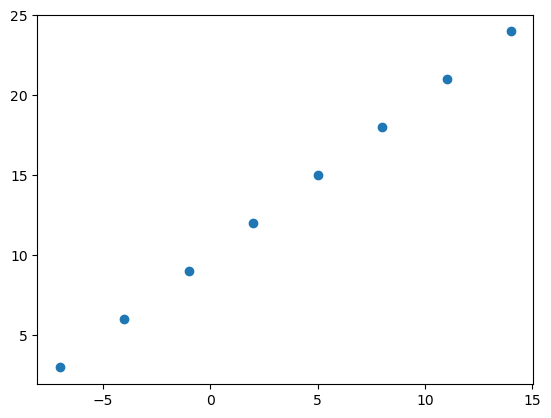

In [7]:
import numpy as np
import matplotlib.pyplot as plt   

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

Before we do any modelling, can you calculate the pattern between `X` and `y`?

For example, say I asked you, based on this data what the `y` value would be if `X` was 17.0?

Or how about if `X` was -10.0?

This kind of pattern discovery is the essence of what we'll be building neural networks to do for us.

## Regression input shapes and output shapes

One of the most important concepts when working with neural networks are the input and output shapes.

The **input shape** is the shape of your data that goes into the model.

The **output shape** is the shape of your data you want to come out of your model.

These will differ depending on the problem you're working on.

Neural networks accept numbers and output numbers. These numbers are typically represented as tensors (or arrays).

Before, we created data using NumPy arrays, but we could do the same with tensors.

In [8]:
# Example input and output shapes of a regression model
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700])>)

In [9]:
house_info.shape

TensorShape([3])

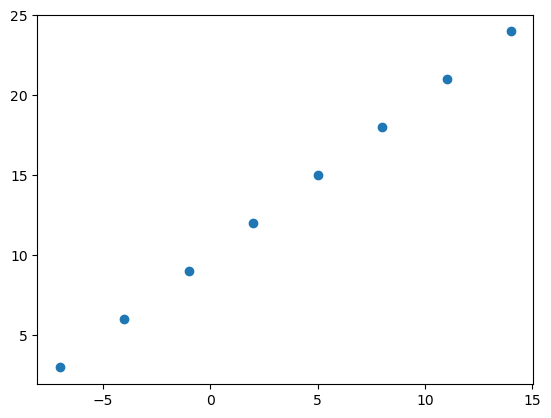

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create features (using tensors)
X = tf.constant([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels (using tensors)
y = tf.constant([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

Our goal here will be to use `X` to predict `y`.

So our **input** will be `X` and our **output** will be `y`.

Knowing this, what do you think our input and output shapes will be?

Let's take a look.

In [14]:
X.shape

TensorShape([8])

In [11]:
# Take a single example of X
input_shape = X[0].shape 

# Take a single example of y
output_shape = y[0].shape

input_shape, output_shape # these are both scalars (no shape)

(TensorShape([]), TensorShape([]))

Huh?

From this it seems our inputs and outputs have no shape?

How could that be?

It's because no matter what kind of data we pass to our model, it's always going to take as input and return as output some kind of tensor.

But in our case because of our dataset (only 2 small lists of numbers), we're looking at a special kind of tensor, more specifically a rank 0 tensor or a scalar.

In [12]:
# Let's take a look at the single examples invidually
X[0], y[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=-7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>)

In our case, we're trying to build a model to predict the pattern between `X[0]` equalling `-7.0` and `y[0]` equalling `3.0`.

So now we get our answer, we're trying to use 1 `X` value to predict 1 `y` value.
**making sure your input and outputs are in the correct shape**

## Steps in modelling with TensorFlow

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 


> **Note:** If you're using [TensorFlow 2.7.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.7.0)+, the `fit()` function no longer upscales input data to go from `(batch_size, )` to `(batch_size, 1)`. To fix this, you'll need to expand the dimension of input data using `tf.expand_dims(input_data, axis=-1)`.
>
> In our case, this means instead of using `model.fit(X, y, epochs=5)`, use `model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)`. 

In [15]:
tf.expand_dims(X, axis=-1)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[-7.],
       [-4.],
       [-1.],
       [ 2.],
       [ 5.],
       [ 8.],
       [11.],
       [14.]], dtype=float32)>

In [13]:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# Fit the model
# model.fit(X, y, epochs=5) # this will break with TensorFlow 2.7.0+
model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 16.0442 - mae: 16.0442
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 15.7629 - mae: 15.7629
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 15.4817 - mae: 15.4817
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 15.2004 - mae: 15.2004
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 14.9311 - mae: 14.9311


In [16]:
# Check out X and y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

What do you think the outcome should be if we passed our model an `X` value of 17.0?

In [17]:
# Make a prediction with the model
model.predict([17.0])

1/1 [==============================] - 0s 69ms/step


array([[-6.461783]], dtype=float32)

It doesn't go very well... it should've output something close to 27.0.

> 🤔 **Question:** What's Keras? I thought we were working with TensorFlow but every time we write TensorFlow code, `keras` comes after `tf` (e.g. `tf.keras.layers.Dense()`)?

Before TensorFlow 2.0+, [Keras](https://keras.io/) was an API designed to be able to build deep learning models with ease. Since TensorFlow 2.0+, its functionality has been tightly integrated within the TensorFlow library.

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [18]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (this time we'll train for longer)
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100) # train for 100 epochs not 10

Epoch 1/100
1/1 [==============================] - 0s 165ms/step - loss: 17.0681 - mae: 17.0681
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 16.7868 - mae: 16.7868
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 16.5056 - mae: 16.5056
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 16.2243 - mae: 16.2243
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 15.9431 - mae: 15.9431
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 15.6618 - mae: 15.6618
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 15.3806 - mae: 15.3806
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 15.0993 - mae: 15.0993
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 14.8487 - mae: 14.8487
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 14.7162 - mae: 14.7162
Epoch 11/100
1/1 [==============================] -

You might've noticed the loss value decrease from before (and keep decreasing as the number of epochs gets higher). 

What do you think this means for when we make a prediction with our model?

How about we try predict on 17.0 again?

In [19]:
# Remind ourselves of what X and y are
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [20]:
# Try and predict what y would be if X was 17.0
model.predict([17.0]) # the right answer is 27.0 (y = X + 10)

1/1 [==============================] - 0s 42ms/step


array([[29.757586]], dtype=float32)

Much better! 

We got closer this time. But we could still be better.

Now we've trained a model, how could we evaluate it?

## Evaluating a model 

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

### Visualize, visualize, visualize

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize." 

This is because you're probably better looking at something (doing) than you are thinking about something.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

But first, we'll create a little bit of a bigger dataset and a new model we can use (it'll be the same as before, but the more practice the better).


In [21]:
# Make a bigger dataset
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [22]:
# Make labels for the dataset (adhering to the same pattern as before)
y = np.arange(-90, 110, 4)
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

Since $y=X+10$, we could make the labels like so:

In [23]:
# Same result as above
y = X + 10
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

## Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you take before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [24]:
# Check how many samples we have
len(X)

50

In [25]:
# Split data into train and test sets
X_train = X[:40] # first 40 examples (80% of data)
y_train = y[:40]

X_test = X[40:] # last 10 examples (20% of data)
y_test = y[40:]

len(X_train), len(X_test)

(40, 10)

## Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.

Let's plot it with some nice colours to differentiate what's what.

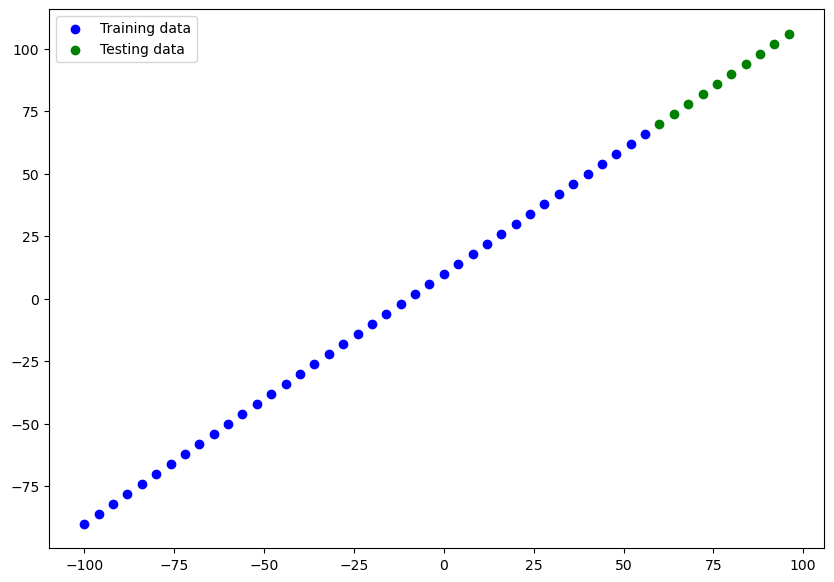

In [26]:
plt.figure(figsize=(10, 7))
# Plot training data in blue
plt.scatter(X_train, y_train, c='b', label='Training data')
# Plot test data in green
plt.scatter(X_test, y_test, c='g', label='Testing data')
# Show the legend
plt.legend();

Beautiful! Any time you can visualize your data, your model, your anything, it's a good idea. 

With this graph in mind, what we'll be trying to do is build a model which learns the pattern in the blue dots (`X_train`) to draw the green dots (`X_test`).

Time to build a model. We'll make the exact same one from before (the one we trained for longer).

In [31]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (same as above)
model.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100) # commented out on purpose (not fitting it just yet)

Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 9.1096 - mae: 9.1096
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 9.5223 - mae: 9.5223
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 11.2067 - mae: 11.2067
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 9.5981 - mae: 9.5981
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 10.5133 - mae: 10.5133
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 9.7336 - mae: 9.7336
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 8.8231 - mae: 8.8231
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 9.0602 - mae: 9.0602
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 19.3948 - mae: 19.3948
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 10.4680 - mae: 10.4680
Epoch 11/100
2/2 [==============================] - 0s 11ms/step - loss

## Visualizing the model

After you've built a model, you might want to take a look at it (especially if you haven't built many before).

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

> 🔑 **Note:** Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [32]:
# Doesn't work (model not fit/built)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Ahh, the cell above errors because we haven't fit or built our model.

We also haven't told it what input shape it should be expecting.

Remember above, how we discussed the input shape was just one number?

We can let our model know the input shape of our data using the `input_shape` parameter to the first layer (usually if `input_shape` isn't defined, Keras tries to figure it out automatically).

In [33]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[1]) # define the input_shape to our model
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [34]:
# This will work after specifying the input shape
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

For now, all you need to think about these parameters is that their learnable patterns in the data.

In [35]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=0) # verbose controls how much gets output

In [36]:
# Check the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Alongside summary, you can also view a 2D plot of the model using [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In our case, the model we used only has an input and an output but visualizing more complicated models can be very helpful for debugging.

## Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [41]:
# Make predictions
y_preds = model.predict(X_test)

1/1 [==============================] - 0s 29ms/step


In [42]:
# View the predictions
y_preds

array([[ 74.60507],
       [ 79.49349],
       [ 84.38191],
       [ 89.27033],
       [ 94.15876],
       [ 99.04718],
       [103.9356 ],
       [108.82402],
       [113.71244],
       [118.60086]], dtype=float32)

Okay, we get a list of numbers but how do these compare to the ground truth labels?

Let's build a plotting function to find out.

> 🔑 **Note:** If you think you're going to be visualizing something a lot, it's a good idea to functionize it so you can use it later.

In [43]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

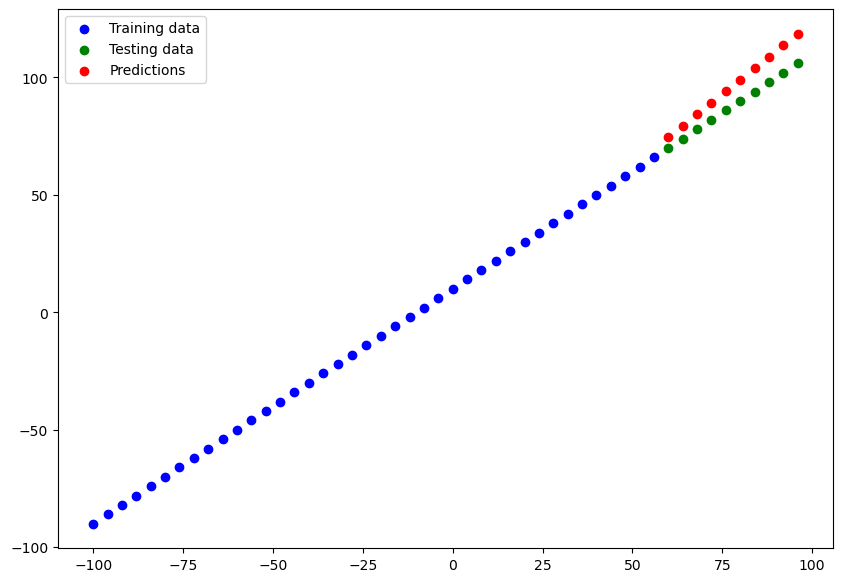

In [44]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

From the plot we can see our predictions aren't totally outlandish but they definitely aren't anything special either.

## Evaluating predictions

Alongisde visualizations, evaulation metrics are your alternative best option for evaluating your model.

Depending on the problem you're working on, different models have different evaluation metrics. 

Two of the main metrics used for regression problems are:
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).

The lower each of these values, the better.

You can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) which will return the loss of the model as well as any metrics setup during the compile step.

In [45]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 533ms/step - loss: 8.6030 - mae: 8.6030


[8.602967262268066, 8.602967262268066]

In our case, since we used MAE for the loss function as well as MAE for the metrics, `model.evaulate()` returns them both.

TensorFlow also has built in functions for MSE and MAE.

For many evaluation functions, the premise is the same: compare predictions to the ground truth labels.

In [46]:
# Calculate the mean absolute error
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds)
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([14.436956, 11.802603, 10.323618, 10.      , 10.863504, 13.028308,
       16.34848 , 20.82402 , 25.712439, 30.60086 ], dtype=float32)>

Huh? That's strange, MAE should be a single output.

Instead, we get 10 values.

This is because our `y_test` and `y_preds` tensors are different shapes.

In [47]:
# Check the test label tensor values
y_test

array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

In [48]:
# Check the predictions tensor values (notice the extra square brackets)
y_preds

array([[ 74.60507],
       [ 79.49349],
       [ 84.38191],
       [ 89.27033],
       [ 94.15876],
       [ 99.04718],
       [103.9356 ],
       [108.82402],
       [113.71244],
       [118.60086]], dtype=float32)

In [49]:
# Check the tensor shapes
y_test.shape, y_preds.shape

((10,), (10, 1))

Remember how we discussed dealing with different input and output shapes is one the most common issues you'll come across, this is one of those times.

But not to worry.

We can fix it using [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze), it'll remove the the `1` dimension from our `y_preds` tensor, making it the same shape as `y_test`.

> 🔑 **Note:** If you're comparing two tensors, it's important to make sure they're the right shape(s) (you won't always have to manipulate the shapes, but always be on the look out, *many* errors are the result of mismatched tensors, especially mismatched input and output shapes).

In [50]:
# Shape before squeeze()
y_preds.shape

(10, 1)

In [51]:
# Shape after squeeze()
y_preds.squeeze().shape

(10,)

In [52]:
# What do they look like?
y_test, y_preds.squeeze()

(array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106]),
 array([ 74.60507,  79.49349,  84.38191,  89.27033,  94.15876,  99.04718,
        103.9356 , 108.82402, 113.71244, 118.60086], dtype=float32))

Okay, now we know how to make our `y_test` and `y_preds` tenors the same shape, let's use our evaluation metrics.

In [53]:
# Calcuate the MAE
mae = tf.metrics.mean_absolute_error(y_true=y_test, 
                                     y_pred=y_preds.squeeze()) # use squeeze() to make same shape
mae

<tf.Tensor: shape=(), dtype=float32, numpy=8.602967>

In [54]:
# Calculate the MSE
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
mse

<tf.Tensor: shape=(), dtype=float32, numpy=80.522705>

We can also calculate the MAE using pure TensorFlow functions.

In [55]:
# Returns the same as tf.metrics.mean_absolute_error()
tf.reduce_mean(tf.abs(y_test-y_preds.squeeze()))

<tf.Tensor: shape=(), dtype=float64, numpy=8.602967071533204>

Again, it's a good idea to functionize anything you think you might use over again (or find yourself using over and over again).

Let's make functions for our evaluation metrics.

In [56]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)
  
def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

## Running experiments to improve a model

After seeing the evaluation metrics and the predictions your model makes, it's likely you'll want to improve it.

Again, there are many different ways you can do this, but 3 of the main ones are:
1. **Get more data** - get more examples for your model to train on (more opportunities to learn patterns).
2. **Make your model larger (use a more complex model)** - this might come in the form of more layers or more hidden units in each layer.
3. **Train for longer** - give your model more of a chance to find the patterns in the data.

Since we created our dataset, we could easily make more data but this isn't always the case when you're working with real-world datasets.

So let's take a look at how we can improve our model using 2 and 3.

To do so, we'll build 3 models and compare their results:
1. `model_1` - same as original model, 1 layer, trained for 100 epochs.
2. `model_2` - 2 layers, trained for 100 epochs.
3. `model_3` - 2 layers, trained for 500 epochs.

**Build `model_1`**

In [57]:
# Set random seed
tf.random.set_seed(42)

# Replicate original model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 5ms/step - loss: 80.2931 - mae: 80.2931
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 44.9106 - mae: 44.9106
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 11.8075 - mae: 11.8075
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 9.3029 - mae: 9.3029
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 10.1676 - mae: 10.1676
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 9.4338 - mae: 9.4338
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 8.5765 - mae: 8.5765
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 9.0672 - mae: 9.0672
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 18.7230 - mae: 18.7230
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 10.1151 - mae: 10.1151
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 30ms/step


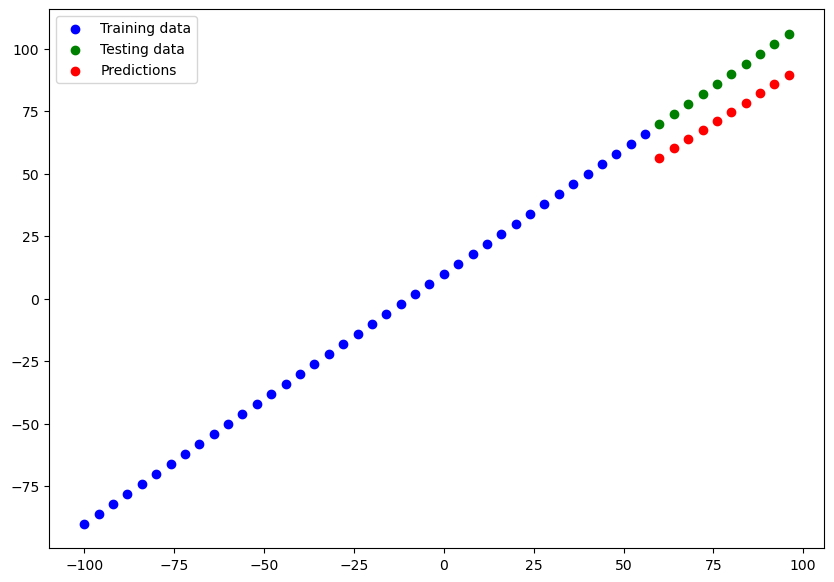

In [58]:
# Make and plot predictions for model_1
y_preds_1 = model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [59]:
# Calculate model_1 metrics
mae_1 = mae(y_test, y_preds_1.squeeze()).numpy()
mse_1 = mse(y_test, y_preds_1.squeeze()).numpy()
mae_1, mse_1

(15.015302, 226.3145)

**Build `model_2`**

This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [60]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_1 and add an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1) # add a second layer
])

# Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100, verbose=0) # set verbose to 0 for less output

1/1 [==============================] - 0s 36ms/step


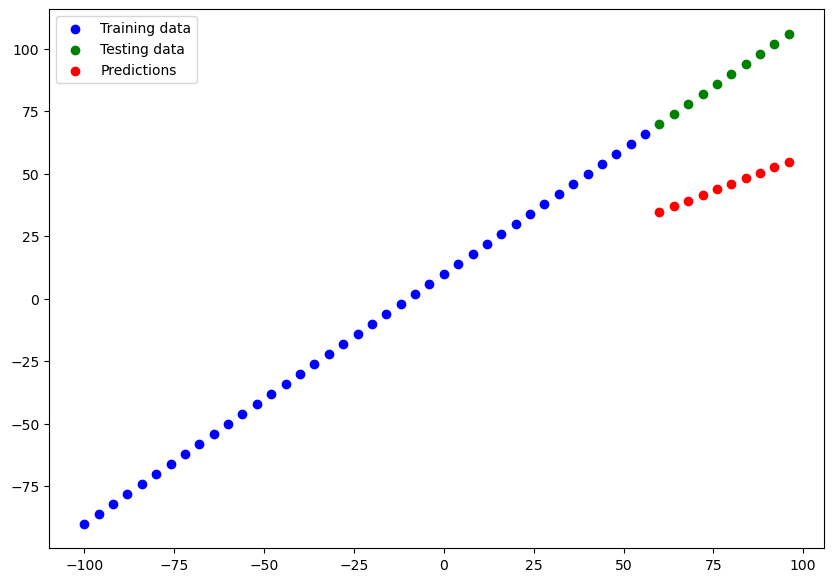

In [61]:
# Make and plot predictions for model_2
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

Woah, that's looking better already! And all it took was an extra layer.

In [62]:
# Calculate model_2 metrics
mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
mae_2, mse_2

(43.164604, 1889.1748)

**Build `model_3`**

For our 3rd model, we'll keep everything the same as `model_2` except this time we'll train for longer (500 epochs instead of 100).

This will give our model more of a chance to learn the patterns in the data.

In [63]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_2
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model (this time for 500 epochs, not 100)
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=0) # set verbose to 0 for less output

1/1 [==============================] - 0s 36ms/step


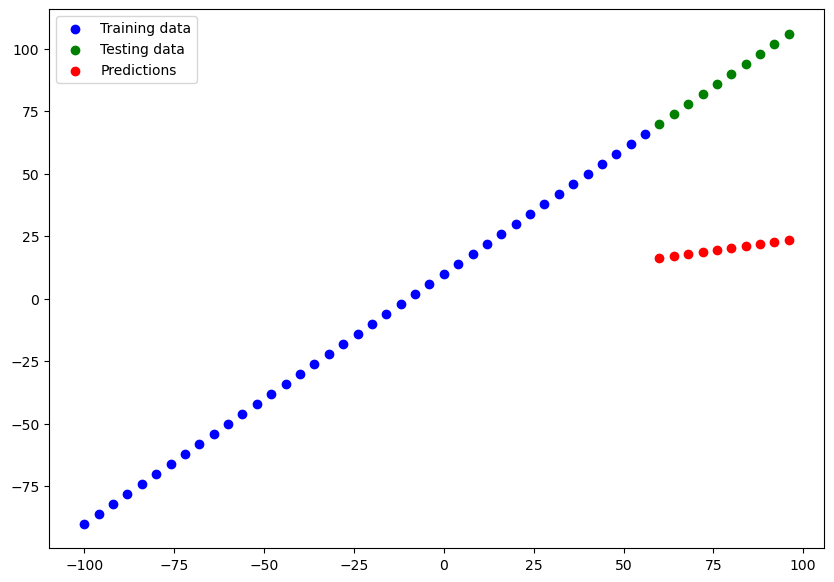

In [64]:
# Make and plot predictions for model_3
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

Strange, we trained for longer but our model performed worse?

As it turns out, our model might've trained too long and has thus resulted in worse results (we'll see ways to prevent training for too long later on).

In [65]:
# Calculate model_3 metrics
mae_3 = mae(y_test, y_preds_3.squeeze()).numpy()
mse_3 = mse(y_test, y_preds_3.squeeze()).numpy()
mae_3, mse_3

(68.09957, 4722.371)

## Comparing results

Now we've got results for 3 similar but slightly different results, let's compare them.

In [66]:
model_results = [["model_1", mae_1, mse_1],
                 ["model_2", mae_2, mse_2],
                 ["model_3", mae_3, mae_3]]

In [68]:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
all_results

,model,mae,mse
0,model_1,15.015302,226.314499
1,model_2,43.164604,1889.174805
2,model_3,68.099571,68.099571


## Saving a model

Once you've trained a model and found one which performs to your liking, you'll probably want to save it for use elsewhere (like a web application or mobile device).

You can save a TensorFlow/Keras model using [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

There are two ways to save a model in TensorFlow:
1. The [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) (default).
2. The [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format).

The main difference between the two is the SavedModel is automatically able to save custom objects (such as special layers) without additional modifications when loading the model back in.

Which one should you use?

It depends on your situation but the SavedModel format will suffice most of the time.

Both methods use the same method call.

In [69]:
# Save a model using the SavedModel format
model_2.save('best_model_SavedModel_format')

INFO:tensorflow:Assets written to: best_model_SavedModel_format\assets


Now let's save the model in the HDF5 format, we'll use the same method but with a different filename.

In [71]:
# Save a model using the HDF5 format
model_2.save("best_model_HDF5_format.h5") # note the addition of '.h5' on the end

## Loading a model

We can load a saved model using the [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) method.

Loading a model for the different formats (SavedModel and HDF5) is the same (as long as the pathnames to the particular formats are correct).

In [72]:
# Load a model from the SavedModel format
loaded_saved_model = tf.keras.models.load_model("best_model_SavedModel_format")
loaded_saved_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
 dense_9 (Dense)             (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Now let's test it out.

In [73]:
# Compare model_2 with the SavedModel version (should return True)
model_2_preds = model_2.predict(X_test)
saved_model_preds = loaded_saved_model.predict(X_test)
mae(y_test, saved_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

1/1 [==============================] - 0s 35ms/step


True

Loading in from the HDF5 is much the same.

In [74]:
# Load a model from the HDF5 format
loaded_h5_model = tf.keras.models.load_model("best_model_HDF5_format.h5")
loaded_h5_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
 dense_9 (Dense)             (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Compare model_2 with the loaded HDF5 version (should return True)
h5_model_preds = loaded_h5_model.predict(X_test)
mae(y_test, h5_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

1/1 [==============================] - 0s 33ms/step


True

## A larger example
More specifically we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

In [76]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [78]:
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [67]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Now we'll split data into features (`X`) and labels (`y`).

In [68]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [69]:
# View features
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


And create training and test sets. We could do this manually, but to make it easier, we'll leverage the already available [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function available from Scikit-Learn.

In [6]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

Now we can build and fit a model (we'll make it the same as `model_2`).

In [143]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['mae'])

# Fit the model
history = insurance_model.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [109]:
# Check the results of the insurance model
insurance_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 236ms/step - loss: 7.8892 - mae: 7.8892


[7.889200687408447, 7.889200687408447]

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

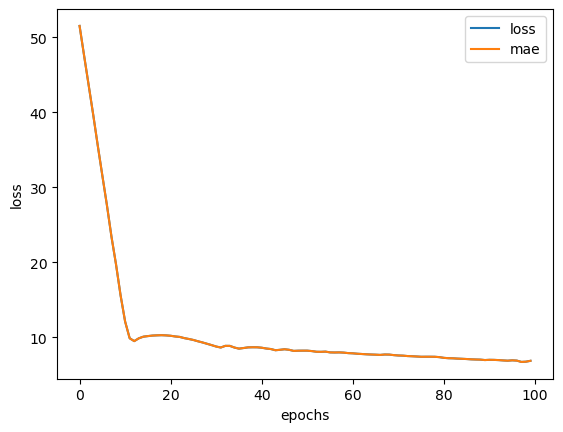

In [110]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [113]:
# Evaluate the model trained for 200 total epochs
insurance_model_loss, insurance_model_mae = insurance_model.evaluate(X_test, y_test)
insurance_model_loss, insurance_model_mae

1/1 [==============================] - 0s 23ms/step - loss: 7.8892 - mae: 7.8892


(7.889200687408447, 7.889200687408447)

Boom! Training for an extra 100 epochs we see about a 10% decrease in error.

How does the visual look?

## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare your data for use with neural networks).

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks you'll tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, I'd recommend reading the following resources:

We've already turned our data into numbers using `get_dummies()`, let's see how we'd normalize it as well.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [4]:
# Check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Now we've normalized it and one-hot encoding it, what does our data look like now?

In [118]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [119]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

How about the shapes?

In [8]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

In [138]:
y_train.shape

(1070,)

In [139]:
X_train_normal.dtype

dtype('float64')

In [140]:
y_train.dtype

dtype('float64')

In [9]:
import tensorflow as tf
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_)
insurance_model.fit(X_train_normal, y_train, epochs=200) 

Epoch 1/200
34/34 [==============================] - 2s 4ms/step - loss: 13343.2041 - mae: 13343.2041
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 13333.9609 - mae: 13333.9609
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 13311.7715 - mae: 13311.7715
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 13266.2314 - mae: 13266.2314
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 13186.7432 - mae: 13186.7432
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 13062.7256 - mae: 13062.7256
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 12883.5918 - mae: 12883.5918
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 12638.6465 - mae: 12638.6465
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 12317.5020 - mae: 12317.5020
Epoch 10/200
34/34 [==============================] - 0s 3ms/step - loss: 11915.48

Let's evaluate the model on normalized test set.

In [10]:
# Evaulate 3rd model
insurance_model_loss, insurance_model_mae = insurance_model.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 3168.9539 - mae: 3168.9539


And finally, let's compare the results from `insurance_model_2` (trained on non-normalized data) and `insurance_model_3` (trained on normalized data).

From this we can see normalizing the data results in 10% less error using the same model than not normalizing the data.

This is **one of the main benefits of normalization: faster convergence time** (a fancy way of saying, your model gets to better results faster).

`insurance_model_2` may have eventually achieved the same results as `insurance_model_3` if we left it training for longer. 

Also, the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

But since our main goal as neural network practitioners is to decrease the time between experiments, anything that helps us get better results sooner is a plus.

## 🛠 Exercises

We've a covered a whole lot pretty quickly.

So now it's time to have a **play around** with a few things and start to build up your intuition.

I emphasise the words play around because that's very important. Try a few things out, run the code and see what happens.

1. Create your own regression dataset (or make the one we created in "Create data to view and fit" bigger) and build fit a model to it.
2. Try building a neural network with 4 Dense layers and fitting it to your own regression dataset, how does it perform?
3. Try and improve the results we got on the insurance dataset, some things you might want to try include:
  * Building a larger model (how does one with 4 dense layers go?).
  * Increasing the number of units in each layer.
  * Lookup the documentation of [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and find out what the first parameter is, what happens if you increase it by 10x?
  * What happens if you train for longer (say 300 epochs instead of 200)? 
4. Import the [Boston pricing dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) from TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and model it.


## 📖 Extra curriculum

If you're looking for extra materials relating to this notebook, I'd check out the following:

* [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - gives a great overview of what's happening behind all of the code we're running.
* Reading: 1-hour of [Chapter 1 of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielson - a great in-depth and hands-on example of the intuition behind neural networks.

To practice your regression modelling with TensorFlow, I'd also encourage you to look through [Lion Bridge's collection of datasets](https://lionbridge.ai/datasets/) or [Kaggle's datasets](https://www.kaggle.com/data), find a regression dataset which sparks your interest and try to model.